In [1]:
import numpy as np
from enum import Enum

import matplotlib.pyplot as plt 
%matplotlib notebook

from scipy.ndimage.filters import uniform_filter1d

import nutripy 

In [2]:
CALORIES_STEP_SIZE=250

class Goal(Enum):
    LOSS = -CALORIES_STEP_SIZE
    MAINTAIN = 0
    GAIN = CALORIES_STEP_SIZE

In [3]:
class UnhandledCaseException(Exception):
    pass

In [4]:
nut = nutripy.nutripy.Nutripy()

In [5]:
def is_close(a, b, close=150):
    if abs(a - b) < close:
        return True
    return False

In [6]:
class Phase(Enum):
    LOSS = 0
    STOP = 1
    MAINTAINANCE = 2 
    GAIN = 3

# Simulation 

In [7]:
"""
Model of weight variation over one week
        - tdci Total Daily Calorie intake is the real number of calories eaten per day
        - tdee Total Daily Energy Expenditure 
        - sigma represent the randomness, the higher the value, the higher the random 
          variations of the weight
          
          Returns the variation of weight aka weight derivative (NOT the weight) in kilograms
"""

def delta_weight(tdci, tdee, sigma=.6):
    return np.random.normal(0, sigma) + ((tdci - tdee) * 7) / 7000 

In [8]:
def gain(x):
    if x > 0.5: 
        return 0
    if x <= 0.5:
        return CALORIES_STEP_SIZE

def maintain(x):
    if x > -0.5 and x < 0.5: 
        return 0
    if x > 0.5:
        return -CALORIES_STEP_SIZE
    if x < 0.5:
        return CALORIES_STEP_SIZE
    
def loss(x):
    if x < -0.5: 
        return 0
    if x > -0.5:
        return -CALORIES_STEP_SIZE

In [34]:
profile_params = {
    "age": 30, 
    "weight": 50, 
    "height": 1.8, 
    "gender": nutripy.nutripy.Gender.MALE, 
    "activity": nutripy.nutripy.Activity.SEDENTARY, 
    "goal": nutripy.nutripy.Goal.GAIN,
}

sim_params = {
    "profile": profile_params,
    "n_weeks": 100,
    
}

In [35]:
def simulate(sim_params):

    weight_history = []
    tdci_history = []
    
    tdee_hat = nut.get_daily_needs(**sim_params["profile"]) # this is the daily expenditure in calories, it should have been estimated at the begining of the program, then, left untouched until it is computed again during Phase.STOP, see code below
    tdci = tdee_hat # tdci is set to tdee_hat but in a real setting, the tdci must be estimated from what the user ate during the week or from its meal plan.
    
    weight_history.append(sim_params["profile"]["weight"])
    tdci_history.append(tdci)
    
    if sim_params["profile"]["goal"] == nutripy.nutripy.Goal.GAIN:
        phases_history = [Phase.GAIN]
    elif sim_params["profile"]["goal"] == nutripy.nutripy.Goal.LOSS:
        phases_history = [Phase.LOSS]
    else:
        raise UnhandledCaseException
        
    for i in range(sim_params["n_weeks"]):
        delta_w = delta_weight(tdci, tdee_hat)
        delta_cal = 0
        
        new_weight = weight_history[-1] + delta_w
        weight_history.append(new_weight)

        current_phase = phases_history[-1]
        duration = 1 # counts the number of weeks within the phase
        
        for i in range(1, len(phases_history)):
            if phases_history[-i-1] == current_phase:
                duration += 1
            else:
                break

        if sim_params["profile"]["goal"] == nutripy.nutripy.Goal.GAIN:
            if current_phase == Phase.GAIN and duration <= 16:
                new_phase = Phase.GAIN

            if current_phase == Phase.GAIN and duration > 16:
                new_phase = Phase.STOP
                duration = 1
                
        elif sim_params["profile"]["goal"] == nutripy.nutripy.Goal.LOSS:
            if current_phase == Phase.LOSS and duration <= 16:
                new_phase = Phase.LOSS
    
            if current_phase == Phase.LOSS and duration > 16:
                new_phase = Phase.STOP
                duration = 1
                
        else:
            raise UnhandledCaseException

        if current_phase == Phase.STOP:
            if is_close(tdee_hat, tdci, close=200):
                new_phase = Phase.MAINTAINANCE
                phases_history.append(new_phase)

                
                
        if new_phase == Phase.MAINTAINANCE:
            if len(weight_history) > 3:
                weight_derivative = np.gradient(weight_history)
                y = uniform_filter1d(weight_derivative, size=3)
                delta_cal = maintain(y[-1])
                
        if sim_params["profile"]["goal"] == nutripy.nutripy.Goal.GAIN:
            if new_phase == Phase.GAIN:
                if len(weight_history) > 3:
                    weight_derivative = np.gradient(weight_history)
                    y = uniform_filter1d(weight_derivative, size=3)
                    delta_cal = gain(y[-1])
            if new_phase == Phase.STOP:
                if duration == 1:
                    params = {k:v for k,v in profile_params.items()}
                    params["weight"] = weight_history[-1]
                    tdee_hat = tdee_hat = nut.get_daily_needs(**params)

                if not is_close(tdee_hat, tdci, close=200):
                    delta_cal = -CALORIES_STEP_SIZE
                
        elif sim_params["profile"]["goal"] == nutripy.nutripy.Goal.LOSS:
            if new_phase == Phase.LOSS:
                if len(weight_history) > 3:
                    weight_derivative = np.gradient(weight_history)
                    y = uniform_filter1d(weight_derivative, size=3)
                    delta_cal = loss(y[-1])
            if new_phase == Phase.STOP:
                if duration == 1:
                        params = {k:v for k,v in profile_params.items()}
                        params["weight"] = weight_history[-1]
                        tdee_hat = tdee_hat = nut.get_daily_needs(**params)

                if not is_close(tdee_hat, tdci, close=200):
                    delta_cal = CALORIES_STEP_SIZE
        else:
            raise UnhandledCaseException


        phases_history.append(new_phase)
        tdci = tdci + delta_cal
        tdci_history.append(tdci)
        
    return weight_history, tdci_history, phases_history

In [36]:
weight_history, tdci_history, phases_history = simulate(sim_params)

<IPython.core.display.Javascript object>


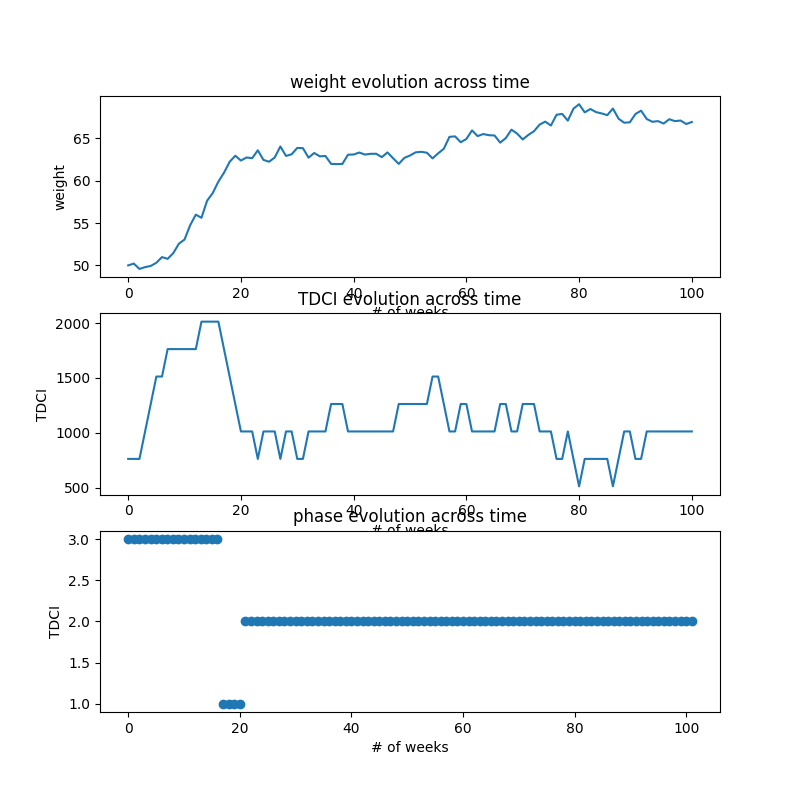

In [37]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(weight_history)


ax2 = fig.add_subplot(312)
ax2.set_ylabel('TDCI')
ax2.set_xlabel('# of weeks')
ax2.set_title('TDCI evolution across time')
ax2.plot(tdci_history)

ax3 = fig.add_subplot(313)
ax3.set_ylabel('TDCI')
ax3.set_xlabel('# of weeks')
ax3.set_title('phase evolution across time')
ax3.scatter(range(len(phases_history)), [x.value for x in phases_history]) 

plt.show()

# API 

Goal: given a user profile, the phases history, the weights history, the tdci history, return the next tdci recommended 

Let's focus on the simplest case, a user has just registered, all we have about the user is it's info given during the onboarding, that is: 

- age,
- weight,
- gender,
- height, 
- activity level,
- goal 

We need to return the estimated daily expenditure based on these values. How do we know that this is the user has just registered? We can simply use the history that should be empty. 

In [38]:
if history.is_empty():
    return nut.get_daily_needs(**profile)

SyntaxError: 'return' outside function (<ipython-input-38-66ec5671b8c2>, line 2)

For the other cases we need: 

IN(user history including current_state) => OUT(new state)

we need the following: 
- new weight 
- phases history
- weight history
- current goal
- current tdci 

In [13]:
def get_new_state(age, height, gender, activity, goal, weight_history, phases_history, tdci, tdee):
    
    assert len(weight_history) == len(phases_history), \
    "weight history should have the same length as phase history"
    
    delta_cal = 0

    new_weight = weight_history[-1]
    current_phase = phases_history[-1]
    
    duration = 1 # counts the number of weeks within the phase

    for i in range(1, len(phases_history)):
        if phases_history[-i-1] == current_phase:
            duration += 1
        else:
            break

    if goal == nutripy.nutripy.Goal.GAIN:
        if current_phase == Phase.GAIN and duration <= 16:
            new_phase = Phase.GAIN

        if current_phase == Phase.GAIN and duration > 16:
            new_phase = Phase.STOP
            duration = 1

    elif goal == nutripy.nutripy.Goal.LOSS:
        if current_phase == Phase.LOSS and duration <= 16:
            new_phase = Phase.LOSS

        if current_phase == Phase.LOSS and duration > 16:
            new_phase = Phase.STOP
            duration = 1

    else:
        raise UnhandledCaseException

    if current_phase == Phase.STOP:
        if is_close(tdee, tdci, close=200):
            new_phase = Phase.MAINTAINANCE
        else:
            new_phase = Phase.STOP
            #phases_history.append(new_phase)
            
    if current_phase == Phase.MAINTAINANCE:
            new_phase = Phase.MAINTAINANCE # todo: renew main Phase or do another goal
      
    print(current_phase)
    if new_phase == Phase.MAINTAINANCE:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = maintain(y[-1])

    if goal == nutripy.nutripy.Goal.GAIN:
        if new_phase == Phase.GAIN:
            if len(weight_history) > 3:
                weight_derivative = np.gradient(weight_history)
                y = uniform_filter1d(weight_derivative, size=3)
                delta_cal = gain(y[-1])
        if new_phase == Phase.STOP:
            if duration == 1:
                tdee = nut.get_daily_needs(age, new_weight, height, gender, activity, goal)
                print(tdee)

            if not is_close(tdee, tdci, close=200):
                delta_cal = -CALORIES_STEP_SIZE

    elif goal == nutripy.nutripy.Goal.LOSS:
        if new_phase == Phase.LOSS:
            if len(weight_history) > 3:
                weight_derivative = np.gradient(weight_history)
                y = uniform_filter1d(weight_derivative, size=3)
                delta_cal = loss(y[-1])
        if new_phase == Phase.STOP:
            if duration == 1:
                    tdee = nut.get_daily_needs(age, new_weight, height, gender, activity, goal)

            if not is_close(tdee, tdci, close=200):
                delta_cal = CALORIES_STEP_SIZE
    else:
        raise UnhandledCaseException


    return {
        "phase": new_phase,
        "tdci": tdci + delta_cal,
        "tdee": tdee
    }

In [18]:
params = {
    "age": 30, 
    "height": 180, 
    "gender": nutripy.nutripy.Gender.MALE, 
    "activity": nutripy.nutripy.Activity.SEDENTARY, 
    "goal": nutripy.nutripy.Goal.GAIN,
    "weight_history": [80, 80, 80.5, 80],
    "phases_history":[Phase.GAIN, Phase.GAIN, Phase.GAIN, Phase.GAIN],
    "tdci": nut.get_daily_needs(30, 80, 180, nutripy.nutripy.Gender.MALE, nutripy.nutripy.Activity.SEDENTARY, nutripy.nutripy.Goal.GAIN),
    "tdee": nut.get_daily_needs(30, 80, 180, nutripy.nutripy.Gender.MALE, nutripy.nutripy.Activity.SEDENTARY, nutripy.nutripy.Goal.GAIN),
}

    
for i in range(20):
        state = get_new_state(**params)
        
        new_phase = state["phase"]
        new_tdci = state["tdci"]
        new_tdee = state["tdee"]
        
        tdci = params["tdci"]
        tdee = params["tdee"]
        
        delta_w = delta_weight(tdci, tdee)
        new_weight = params["weight_history"][-1] + delta_w
        
        params["phases_history"].append(new_phase)
        params["weight_history"].append(new_weight)
        
        params["tdci"] = new_tdci
        params["tdee"] = new_tdee
        


Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
Phase.GAIN
2901.8666665050264
Phase.STOP
2915.6042804039544
Phase.STOP
Phase.STOP
Phase.STOP
Phase.MAINTAINANCE
Phase.MAINTAINANCE


In [19]:
params

{'age': 30,
 'height': 180,
 'gender': <Gender.MALE: 5>,
 'activity': <Activity.SEDENTARY: 1.4>,
 'goal': <Goal.GAIN: 250>,
 'weight_history': [80,
  80,
  80.5,
  80,
  79.72629123615464,
  80.9989393468775,
  82.20927003925227,
  83.2987932212371,
  82.4299422886702,
  82.96597476549172,
  84.40194097944632,
  83.99692945742567,
  84.930921607453,
  86.44500272969256,
  88.2792340606551,
  89.7817415104467,
  91.4190476075019,
  92.40030574313963,
  92.83812187709121,
  92.97319560696216,
  93.83316031619442,
  93.47798547909902,
  92.39624019470435,
  92.3360606651626],
 'phases_history': [<Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.GAIN: 3>,
  <Phase.STOP: 1>,
  <Phase.STOP: 1>,
  <Phase.STOP: 1>,
  <Phase.STOP: 1>,
  <

<IPython.core.display.Javascript object>


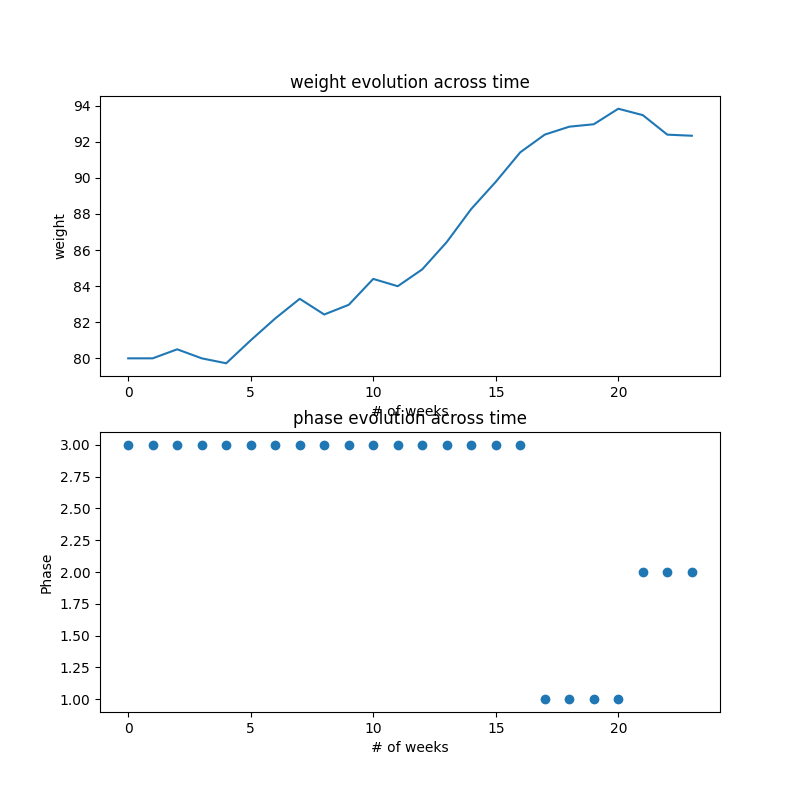

In [29]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(211)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(params["weight_history"])



ax3 = fig.add_subplot(212)
ax3.set_ylabel('Phase')
ax3.set_xlabel('# of weeks')
ax3.set_title('phase evolution across time')
ax3.scatter(range(len(params["phases_history"])), [x.value for x in params["phases_history"]]) 

plt.show()